In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys

In [2]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/TRIO_data/')

Try loading a niFti dataset of a single patient (single scan)

In [3]:
os.chdir('./Subj10Scan1/')

In [4]:
img = nib.load("NODDI_3Shells.nii.gz")
data = img.get_data()

In [5]:
#get the dimestions of the dataset
print(data.shape)

(96, 96, 55, 117)


In [6]:
#get the size/dimensions of each voxel
print(img.header.get_zooms()[:3])

(2.5, 2.5, 2.5)


Try visualizing the dataset using matplotlib. For example, let’s show the middle axial slices of volume 0 and volume 10.

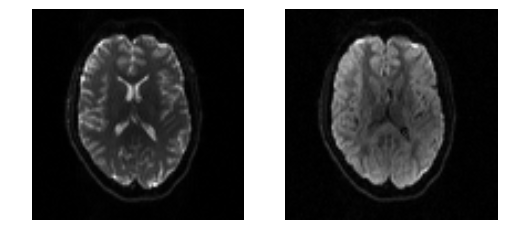

In [7]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.show()

Try visualising the data at the intersection of a voxel e.g (x=40,y=40,z=20)

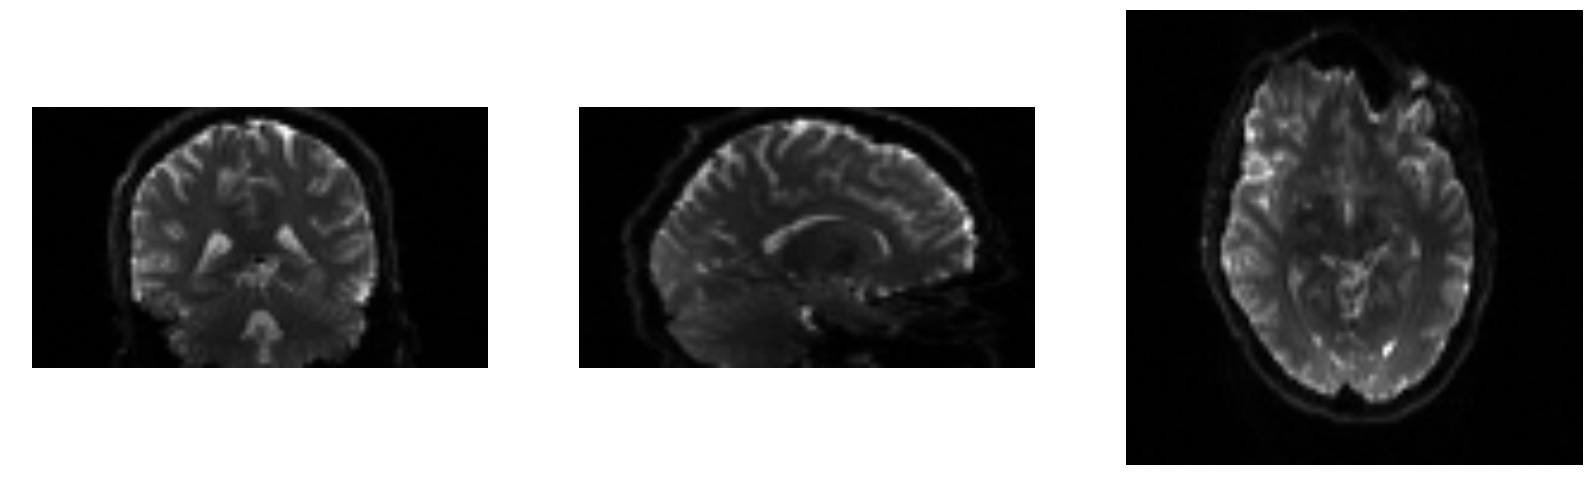

In [8]:
plt.figure
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(data[:, 40, :, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(data[40, :, :, 0].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(data[:, :, 20, 0].T, cmap='gray', origin='lower')
plt.show()


Next load Bval and Bvec files

In [9]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

Use a GradientTable object to hold all the acquisition specific parameters, e.g. b-values, b-vectors. Use function gradient_table to create the object.

In [10]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [11]:
print(gtab.info)

B-values shape (117,)
         min 5.000000 
         max 2000.000000 
B-vectors shape (117, 3)
         min -0.997205 
         max 0.999862 
None


In [12]:
print(gtab.bvals)

[    5.   700.   700.   700.   700.   700.   700.   700.   700.     5.
   700.   700.   700.   700.   700.   700.   700.   700.     5.   700.
   700.   700.   700.   700.   700.   700.   700.     5.   700.   700.
   700.   700.   700.   700.   700.   700.     5.  2000.  2000.  2000.
  2000.  2000.  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.
  2000.  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.
  2000.  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.
  2000.  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.
  2000.     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.
     5.  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.     5.
  2000.  2000.  2000.  2000.  2000.  2000.  2000.  2000.     5.   300.
   300.   300.   300.   300.   300.   300.   300.]


In [13]:
#print the first 10 bvectors (notation is the same as matlib matrix indexing)
print(gtab.bvecs[:10, :])

[[-0.5773502  -0.56513256  0.58931476]
 [ 0.51869565  0.85274225 -0.06152632]
 [ 0.80059832 -0.0819406  -0.59357226]
 [ 0.51508027  0.71643335 -0.47054818]
 [ 0.11831205  0.96070033 -0.25111184]
 [-0.46743399 -0.56365108 -0.68103075]
 [ 0.71663481  0.21114066  0.66472107]
 [ 0.5994221  -0.50575012 -0.62041116]
 [-0.8000164   0.21150333 -0.56146246]
 [-0.5773502  -0.56513256  0.58931476]]


In [14]:
#another way to get the shape of numpy arrays
gtab.bvecs.shape

(117, 3)

### Perform tensor fitting on PETMR dataset

In [98]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/')

In [99]:
os.chdir('./Subj1Scan1/')

In [100]:
imgS1S1 = nib.load("NODDI_3Shells.nii.gz")
dataS1S1= imgS1S1.get_data()

In [101]:
dataS1S1.shape

(96, 96, 55, 117)

#### Load the Bvec and Bval files for this particular subject and scan

In [102]:
from dipy.io import read_bvals_bvecs
bvalsS1S1, bvecsS1S1 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

In [103]:
from dipy.core.gradients import gradient_table
gtabS1S1 = gradient_table(bvalsS1S1, bvecsS1S1)

In [104]:
gtabS1S1.bvecs.shape

(117, 3)

### Reconstruct the diffusion signal using a simple tensor model

In [105]:
import dipy.reconst.dti as dti

#### First of all, we mask and crop the data. This is a quick way to avoid calculating Tensors on the background of the image

In [106]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(dataS1S1, 3, 1, True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (54, 66, 55, 117)


Simple brain extraction tool method for images from DWI data.

It uses a median filter smoothing of the input_volumes vol_idx and an automatic histogram Otsu thresholding technique, hence the name median_otsu.

#### Perform voxel reconstruction

In [107]:
tenmodel = dti.TensorModel(gtabS1S1)

#fitting performed using Weighted least squares by default, but can specify other method
tenfit = tenmodel.fit(maskdata)

In [108]:
print('Computing anisotropy(FA)')
from dipy.reconst.dti import fractional_anisotropy

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy(FA)


In [109]:
FA[np.isnan(FA)] = 0

In [110]:
FA.shape

(54, 66, 55)

In [111]:
#affine matrix converts voxels coordinates and returns scanner space coordinates
fa_img = nib.Nifti1Image(FA.astype(np.float32), imgS1S1.affine)
nib.save(fa_img, 'tensor_fa.nii.gz')

In [112]:
fa_data = fa_img.get_data()
fa_data.shape

(54, 66, 55)

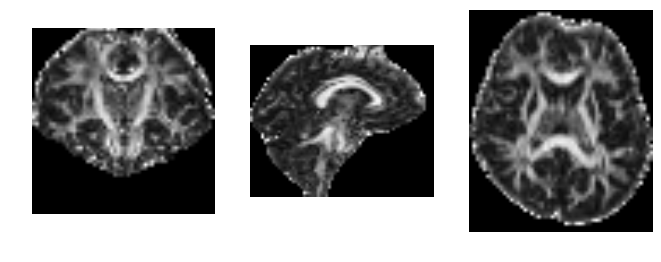

Brighter areas represent regions of higher anisotropic diffusion


In [182]:
plt.figure
plt.figure(figsize=(8,8))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(fa_data[:, 33, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(fa_data[29, :, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(fa_data[:, :, 35].T, cmap='gray', origin='lower')
plt.show()
print("Brighter areas represent regions of higher anisotropic diffusion")

In [127]:
tenfit.evecs.shape

(54, 66, 55, 3, 3)

In [125]:
from dipy.reconst.dti import color_fa
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
RGB_img = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), imgS1S1.affine)
nib.save(RGB_img, 'tensor_rgb.nii.gz')

In [128]:
RGB_data = RGB_img.get_data()
RGB_data.shape
RGB_data[:, 20, 35, 2]

array([  0,   0,   0,  13, 134,  32,   7,   1,  10,   3,   5,  15,  32,
        36, 100,  80,  17,  23,   9,  15,  29,  12,  19,  16,  22,  74,
        41,   6,  15,  20,  66, 125, 104,  95,  48,  27, 113, 122,  46,
        13, 172,  87,   0,   5,   4,  13,  19,  17,  22,   9,  13,  43,
        13,   0], dtype=uint8)

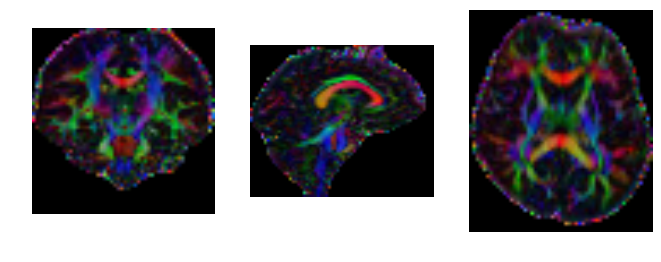

Color Fractional Anisotropy Map


In [183]:
plt.figure
plt.figure(figsize=(8,8))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(RGB_data[:, 30, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(RGB_data[29, :, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(RGB_data[:, :, 35, :].transpose(1,0,2), origin='lower')
plt.show()
print("Color Fractional Anisotropy Map")

## Perform tensor fitting on TRIO dataset

In [57]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/TRIO_data/Subj1Scan1/')

In [60]:
imgS1S1_2 = nib.load("NODDI_3Shells.nii.gz")
dataS1S1_2 = imgS1S1_2.get_data()
dataS1S1_2.shape

(96, 96, 55, 117)

In [63]:
from dipy.io import read_bvals_bvecs
bvalsS1S1_2, bvecsS1S1_2 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

from dipy.core.gradients import gradient_table
gtabS1S1_2 = gradient_table(bvalsS1S1_2, bvecsS1S1_2)

In [66]:
import dipy.reconst.dti as dti

from dipy.segment.mask import median_otsu
maskdata2, mask2 = median_otsu(dataS1S1_2, 3, 1, True, dilate=2)
print('maskdata2.shape (%d, %d, %d, %d)' % maskdata2.shape)

maskdata2.shape (58, 66, 54, 117)


#### Fit tensor model to data

In [67]:
tenmodel2 = dti.TensorModel(gtabS1S1_2)

#fitting performed using Weighted least squares by default, but can specify other method
tenfit2 = tenmodel2.fit(maskdata2)

In [68]:
print('Computing anisotropy(FA)')
from dipy.reconst.dti import fractional_anisotropy

FA2 = fractional_anisotropy(tenfit2.evals)
FA2[np.isnan(FA2)] = 0

Computing anisotropy(FA)


In [69]:
#affine matrix converts voxels coordinates and returns scanner space coordinates
fa_img2 = nib.Nifti1Image(FA2.astype(np.float32), imgS1S1_2.affine)
nib.save(fa_img2, 'tensor_fa.nii.gz')

In [70]:
fa_data2 = fa_img2.get_data()
fa_data2.shape

(58, 66, 54)

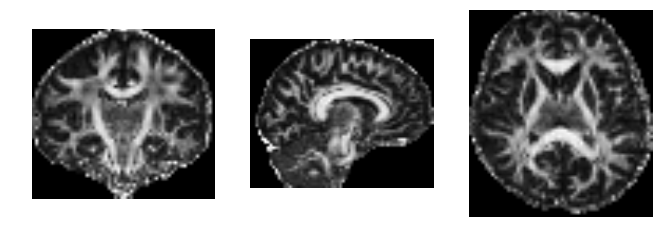

Brighter areas represent regions of higher anisotropic diffusion


In [197]:
plt.figure
plt.figure(figsize=(8,8))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(fa_data2[:, 33, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(fa_data2[25, :, :].T, cmap='gray', origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(fa_data2[:, :, 27].T, cmap='gray', origin='lower')
plt.show()
print("Brighter areas represent regions of higher anisotropic diffusion")

In [75]:
from dipy.reconst.dti import color_fa
FA2 = np.clip(FA2, 0, 1)
RGB2 = color_fa(FA2, tenfit2.evecs)
RGB_img2 = nib.Nifti1Image(np.array(255 * RGB2, 'uint8'), imgS1S1_2.affine)
nib.save(RGB_img2, 'tensor_rgb.nii.gz')

In [87]:
RGB_data2 = RGB_img2.get_data()
RGB_data2.shape

(58, 66, 54, 3)

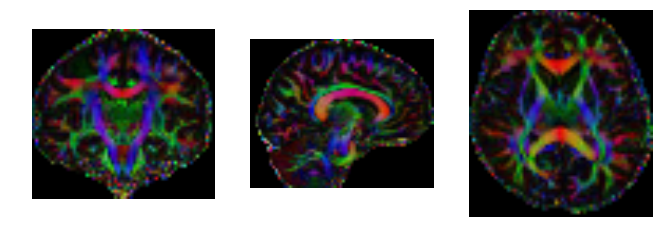

Color Fractional Anisotropy Map


In [196]:
plt.figure
plt.figure(figsize=(8,8))
plt.subplot(1, 3, 1).set_axis_off()
plt.imshow(RGB_data2[:, 33, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 2).set_axis_off()
plt.imshow(RGB_data2[25, :, :, :].transpose(1,0,2), origin='lower')
plt.subplot(1, 3, 3).set_axis_off()
plt.imshow(RGB_data2[:, :, 27, :].transpose(1,0,2), origin='lower')
plt.show()
print("Color Fractional Anisotropy Map")

-----------------------------------------------------------------------------------------------------------
---



-----


-----------------------------------------------------------------------------------------------------------
---

# Develop CNN for b=0 values 

In [2]:
import os
import nibabel as nib
import numpy as np
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
from dipy.segment.mask import applymask
from dipy.segment.mask import bounding_box

----

### Get PETMR data for subject 1 scan 1

In [328]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan1/')
imgScan1 = nib.load("NODDI_3Shells.nii.gz")
dataScan1 = imgScan1.get_data()
print("Shape of data: (%d, %d, %d, %d)" % dataScan1.shape)

bvalsScan1, bvecsScan1 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

gtabScan1 = gradient_table(bvalsScan1, bvecsScan1)


Shape of data: (96, 96, 55, 117)


#### Mask and crop the data to extract the brain

In [329]:
maskDataScan1, maskScan1 = median_otsu(dataScan1, 3, 3, True, dilate=2)
print('Shape of Masked Data Scan1: (%d, %d, %d, %d)' % maskDataScan1.shape)

Shape of Masked Data Scan1: (53, 61, 53, 117)


#### Extract b=0 volumes from scan 1

In [330]:
S0sScan1 = maskDataScan1[:, :, :, gtabScan1.b0s_mask]
print(S0sScan1.shape)

(53, 61, 53, 13)


In [331]:
brainImg1 = nib.Nifti1Image(S0sScan1.astype(np.float32), imgScan1.affine)
nib.save(brainImg1, '/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan1/brain_dipy.nii.gz' )

-----

### Get PETMR data for subject 1 scan 2

In [332]:
os.chdir('/Users/ShivamDhall/Desktop/Project/Dataset/PETMR_data/Subj1Scan2/')
imgScan2 = nib.load("NODDI_3Shells.nii.gz")
dataScan2 = imgScan2.get_data()
print("Shape of data: (%d, %d, %d, %d)" % dataScan2.shape)
bvalsScan2, bvecsScan2 = read_bvals_bvecs('NODDI.bval', 'NODDI.bvec')

gtabScan2 = gradient_table(bvalsScan2, bvecsScan2)

Shape of data: (96, 96, 55, 117)


#### Mask and crop the data to extract the brain

In [333]:
maskDataScan2, maskScan2 = median_otsu(dataScan2, 3, 3, True, dilate=2)
print('Shape of Masked Data Scan2: (%d, %d, %d, %d)' % maskDataScan2.shape)

Shape of Masked Data Scan2: (55, 64, 53, 117)


#### Extract b=0 volumes from scan 2

In [334]:
S0sScan2 = maskDataScan2[:, :, :, gtabScan2.b0s_mask]
print(S0sScan2.shape)



(55, 64, 53, 13)


---

## Visually compare the 2 scans

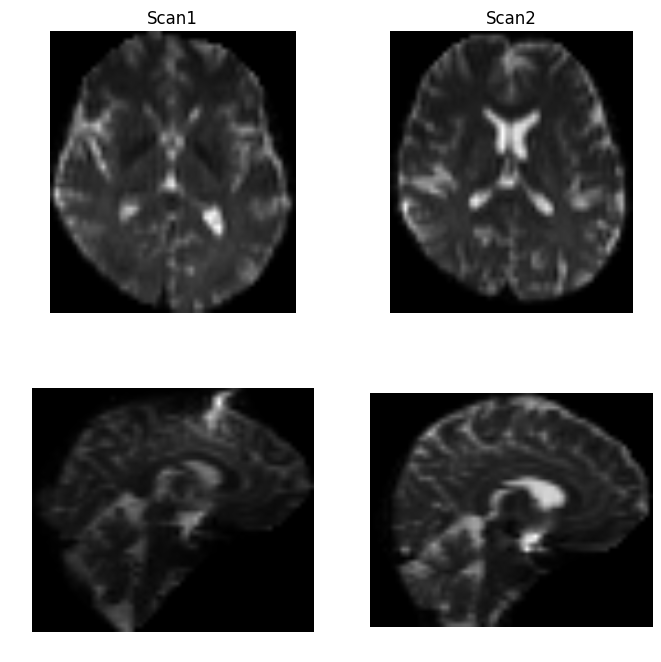

In [335]:
plt.figure
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(S0sScan1[:, :, 30, 0].T, cmap='gray', origin='lower')
plt.title("Scan1")
plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(S0sScan2[:, :, 30, 0].T, cmap='gray', origin='lower')
plt.title("Scan2")
plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(S0sScan1[25, :, :, 0].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(S0sScan2[25, :, :, 0].T, cmap='gray', origin='lower')
plt.show()

In [336]:
print(imgScan1.header.get_zooms()[:3])
print(S0sScan1.shape)
print("")
print(imgScan2.header.get_zooms()[:3])
print(S0sScan2.shape)

(2.5, 2.5, 2.5000007)
(53, 61, 53, 13)

(2.5, 2.5, 2.5000007)
(55, 64, 53, 13)


In [337]:
np.array_equal(S0sScan1, S0sScan2)

False

----

## Find variance of voxel values across b=0 volumes for scan 1

In [8]:
#pick a random voxel and display the intensity values across all volmes
print("Voxel (1,1,1) = %s" % S0sScan1[1,1,1,:])
print("Voxel (45,45,25) = %s" % S0sScan1[45,45,25,:])


Voxel (1,1,1) = [0 0 0 0 0 0 0 0 0 0 0 0 0]
Voxel (45,45,25) = [14 18  1 10 30 15 16 28  0 11 12 26 18]


In [9]:
print("max intensity value = %d" % np.max(S0sScan1))
print("min intensity value = %d" % np.min(S0sScan1))

variance = np.var(S0sScan1, 3)
std = np.std(S0sScan1, 3)

print("mean of variance = %f" % np.mean(variance))
print("mean of std = %f" % np.mean(std))

std.shape

max intensity value = 4095
min intensity value = 0
mean of variance = 766.894987
mean of std = 12.817002


(53, 61, 53)

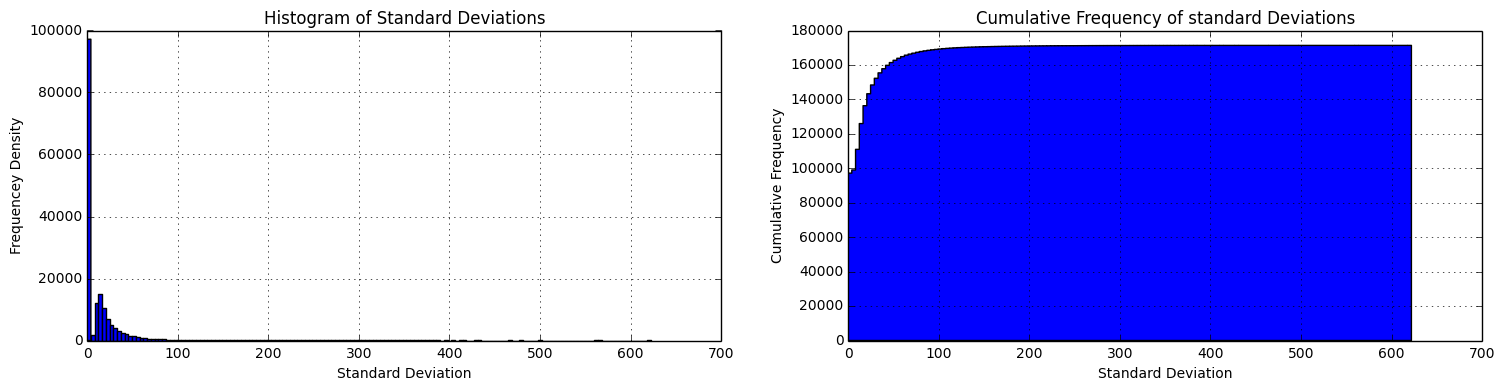

In [10]:
# the histogram of the data
plt.figure
plt.figure(figsize=(18,4))

plt.subplot(1,2,1)
plt.hist(std.ravel(), 150, histtype = 'bar')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequencey Density')
plt.title('Histogram of Standard Deviations')
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(std.ravel(), 150, cumulative=True, histtype = 'stepfilled')
plt.xlabel('Standard Deviation')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Frequency of standard Deviations')
plt.grid(True)


## Develop CNN to predict b=0 values for scan 1

#### Split the data into training and testing sets

Since we have 13 b=0 volumees, we split the data into 10 for training and 2 for testing (1 volume remains unused)

In [43]:
#Split the data into testing and training
training_inputs = S0sScan1[:, :, :, 0:10:2]
training_outputs = S0sScan1[:, :, :, 1:10:2]
testing_inputs = S0sScan1[:, :, :, 10]
testing_outputs = S0sScan1[:, :, :, 11]

#### Normalise the training and testing data

In [44]:
def normalise(dataset, mean=None, std=None):
    if mean == None and std == None:
        #compute the mean and standard deviation of each channel of the dataset
        #for now we assume we have a single channel, but this can easily be changed later
        mean = np.mean(dataset)
        std = np.std(dataset)
        dataset = (dataset - mean)/std
        return (dataset, mean, std)
    else:
        #apply mean and std to normalise the dataset
        dataset = (dataset - mean)/std
        return dataset

In [45]:
#Normalise the data
(training_inputs, training_input_mean, training_input_std) = normalise(training_inputs)
(training_outputs, training_output_mean, training_output_std) = normalise(training_outputs)
testing_inputs = normalise(testing_inputs, training_input_mean, training_input_std)
testing_outputs = normalise(testing_outputs, training_output_mean, training_output_std)

#### Create Pytorch upload pipeline

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [69]:
#create a dataset for class for our data

class MRIdataset(Dataset):
    """MRI b=0 dataset for scan1."""

    def __init__(self, inputs, outputs, transform=None, size=None):
        """
        Args:
            inputs: Input data
            outputs: Corresponding outputs of the input data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.inputs = inputs
        self.outputs = outputs
        self.transform = transform
        self.size = size

    def __len__(self):
        if not self.size:
            return self.inputs.shape[3]
        else:
            return 1

    def __getitem__(self, idx):
        if not self.size:
            sample = {'inp': self.inputs[:,:,:,idx], 'out': self.outputs[:,:,:,idx]}
        else:
            sample = {'inp': self.inputs, 'out': self.outputs}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [70]:
class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        inp, out = sample['inp'], sample['out']
        
        #first expand dimension because torch expects H x W x D x C
        aug_inp = np.expand_dims(inp, 3)
        aug_out = np.expand_dims(out, 3)

        # swap channel axis because
        # numpy: H x W x D x C
        # torch: C x D x H x W
        aug_inp = aug_inp.transpose((3, 2, 0, 1))
        aug_out = aug_out.transpose((3, 2, 0, 1))
        return {'inp': torch.Tensor(aug_inp),
                'out': torch.Tensor(aug_out)}

#This class might not be needed as it may be implemented in pytorch cov functions
class Pad(object):
    """Pad the input volume before transformation to Tensor"""
    
    def __call__(self, sample):
        inp, out = sample['inp'], sample['out']
    
        #Currently the dimension is H x W x D
        #Note the amount of padding depends on the architecture of the CNN being used
        npad = ((2,2), (2, 2), (2, 2))
        aug_inp = np.pad(inp, pad_width=npad, mode='constant', constant_values=0)
        return {'inp': torch.Tensor(aug_inp),
                'out': torch.Tensor(out)}
            

#### Upload the data to pytorch data loaders

In [71]:
training_dataset = MRIdataset(training_inputs, training_outputs, transform=transforms.Compose([To_Tensor()]))
testing_dataset = MRIdataset(testing_inputs, testing_outputs, transform=transforms.Compose([To_Tensor()]), size=1)

In [72]:
trainloader = DataLoader(training_dataset, batch_size=4,
                        shuffle=True, num_workers=2)
testloader = DataLoader(testing_dataset, batch_size=4,
                        shuffle=True, num_workers=2)

In [73]:
dataloader = DataLoader(training_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['inp'].size(),
          sample_batched['out'].size())

(0, torch.Size([4, 1, 53, 53, 61]), torch.Size([4, 1, 53, 53, 61]))
(1, torch.Size([1, 1, 53, 53, 61]), torch.Size([1, 1, 53, 53, 61]))


In [74]:
testing_inputs.shape

(53, 61, 53)

In [75]:
for i_batch, sample_batched in enumerate(testloader):
    print(i_batch, sample_batched['inp'].size(),
          sample_batched['out'].size())

(0, torch.Size([1, 1, 53, 53, 61]), torch.Size([1, 1, 53, 53, 61]))


#### Develop the CNN

Conv -> Relu -> Conv -> Relu -> Conv

--(53x61x53x1)--

conv1 = receptive field -> (3x3x3), zero padding -> 2,  number of filters -> 50

--(55x63x55x50)--

conv2 = receptive field -> (1x1x1), number of filters -> 100

--(55x63x55x100)--

conv3 = receptive field -> (3x3x3), number of filters -> 1

--(53x61x53x1)--


In [273]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 2, 3, padding=2)
        self.conv2 = nn.Conv3d(2, 2, 1)
        self.conv3 = nn.Conv3d(2, 1, 3)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


net = Net()
print(net)

Net (
  (conv1): Conv3d(1, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv2): Conv3d(2, 2, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv3): Conv3d(2, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1))
)


#### Train the CNN

In [274]:
import torch.optim as optim
#here we use MSE loss
criterion = nn.MSELoss(size_average=False) #returns the sum over a mini-batch as opposed to the average
optimizer = optim.SGD(net.parameters(), lr=0.00000001, momentum=0.9)

In [275]:
#create an array to hold the MSE loss for each iteration
MSE_losses = []
MSE_acc = []

In [361]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #done in batches
        # get the inputs
        inputs = data['inp']
        labels = data['out']

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize/update weights
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0] #loss is a variable tensor of size 1, we index to get the value out
        print('[%d, %5d]' % (epoch + 1, i + 1))
    MSE_loss = running_loss / 5
    MSE_losses.append(MSE_loss)
    print('MSE Loss iteration %d = %.5f' % (epoch+1, MSE_loss ))
    
    test_error = 0
    total = 0
    for test_data in testloader: #batch processing
        test_inputs = test_data['inp']
        test_labels = test_data['out']
        total += len(test_labels)
        
        test_outputs = net(Variable(test_inputs))
        
        #test_error += torch.nn.functional.mse_loss(test_outputs.data, test_labels, size_average=False)
        print(torch.nn.functional.mse_loss(test_outputs.data, test_labels, size_average=False)).data[0]
        
   # test_error /= total
    #print('MSE on test data: %d' % (test_error.data[0]))
    #MSE_acc.append(test_error.data[0])
    
print('Finished Training')

[1,     1]
[1,     2]
MSE Loss iteration 1 = 28377.31445
28505.1953125
[2,     1]
[2,     2]
MSE Loss iteration 2 = 28286.19219
28419.5898438
[3,     1]
[3,     2]
MSE Loss iteration 3 = 28200.67188
28332.8671875
[4,     1]
[4,     2]
MSE Loss iteration 4 = 28115.09648
28246.8867188
[5,     1]
[5,     2]
MSE Loss iteration 5 = 28030.76562
28162.0039062
[6,     1]
[6,     2]
MSE Loss iteration 6 = 27946.99766
28079.4648438
[7,     1]
[7,     2]
MSE Loss iteration 7 = 27865.31602
27996.6269531
[8,     1]
[8,     2]
MSE Loss iteration 8 = 27784.84297
27915.734375
[9,     1]
[9,     2]
MSE Loss iteration 9 = 27704.05469
27835.0898438
[10,     1]
[10,     2]
MSE Loss iteration 10 = 27621.64492
27755.2421875
[11,     1]
[11,     2]
MSE Loss iteration 11 = 27543.92578
27674.8046875
[12,     1]
[12,     2]
MSE Loss iteration 12 = 27466.57188
27600.1171875
[13,     1]
[13,     2]
MSE Loss iteration 13 = 27388.79688
27522.8574219
[14,     1]
[14,     2]
MSE Loss iteration 14 = 27310.59180
27444.

ValueError: x and y must have same first dimension

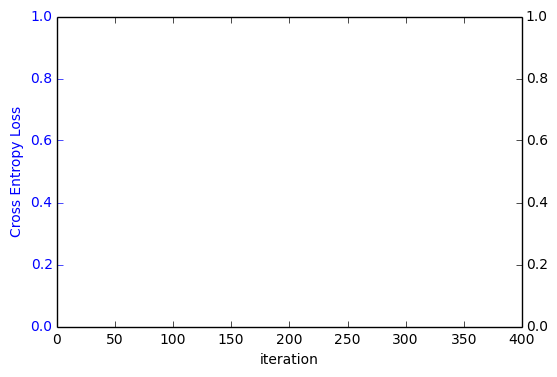

In [372]:
fig, ax1 = plt.subplots()
ax1.plot(range(1,401), MSE_losses, 'b-')
ax1.set_xlabel('iteration')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Cross Entropy Loss', color='b')
ax1.set_ylim([0,1])
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(range(1,401), MSE_acc, 'r-')
ax2.set_ylabel('Accuracy', color='r')
ax2.set_ylim([0,100])
ax2.tick_params('y', colors='r')


plt.show()

400

In [362]:
for test_data in testloader: #batch processing
        test_inputs = test_data['inp']
        test_labels = test_data['out']
        total += len(test_labels)
        
        test_outputs = net(Variable(test_inputs))
        predicted_data = test_outputs.data[0].numpy()
        print ('Minimum voxel intensity prediction: %f' %torch.min(test_outputs.data[0]))
        print ('Maximum voxel intensity prediction: %f' %torch.max(test_outputs.data[0]))
        print ('Mean voxel intensity prediction: %f' %torch.mean(test_outputs.data[0]))
        print ('std voxel intensity prediction: %f' %torch.std(test_outputs.data[0]))

Minimum voxel intensity prediction: -2.127500
Maximum voxel intensity prediction: 4.879250
Mean voxel intensity prediction: -0.018691
std voxel intensity prediction: 0.880812


#### Un-normalise the predicted data

In [363]:
#reshape the array to be W x H x D
predicted_data = predicted_data.transpose(2,3,1,0)
predicted_data.shape

(53, 61, 53, 1)

In [364]:
predicted_data = (predicted_data * training_output_std) + training_output_mean

In [365]:
predicted_data[predicted_data < 0] = 0

#### Display the results

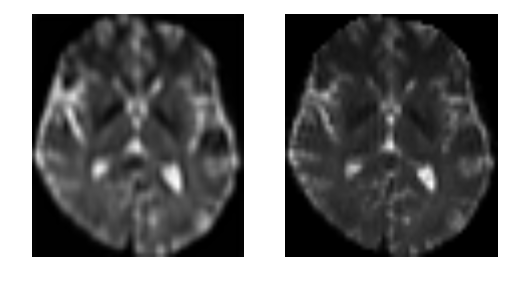

In [366]:
plt.figure
plt.subplot(1,2,1).set_axis_off()
plt.imshow(predicted_data[:, :, 30, 0].T, cmap='gray', origin='lower')
plt.subplot(1,2,2)
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(S0sScan1[:, :, 30, 11].T, cmap='gray', origin='lower')